In [1]:
import torch
import os
import monai.transforms as mt
import monai.data as md
import scipy.io as sio
import numpy as np
from liutuo_utils import compare_3d_jet,compare_3d,donkey_noise_like
import matplotlib.pyplot as plt
import pandas as pd
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()
device_id =0

# 设置 PyTorch 的默认 CUDA 设备
torch.cuda.set_device(device_id)

# 确认当前默认 CUDA 设备
current_device = torch.cuda.current_device()
print(f"Switched to CUDA device: {current_device}")

/home/pnxc/Anaconda3/envs/xiaochou/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0+unknown
Numpy version: 2.2.4
Pytorch version: 2.6.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b96aedc48ad2da16149490b06a1a6bd8361335
MONAI __file__: /home/ssddata/<username>/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: 2.19.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu118
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, p

In [3]:
import os
import pandas as pd
import torch
from transformers import AutoProcessor, AutoModel
import scipy.io as sio

# 读取CSV文件并创建Subject到Description和Group的映射
label_path= "/home/ssddata/liutuo/liutuo_data/filtered_subjects_with_description.csv"
label = pd.read_csv(label_path)
label_dict = dict(zip(label["Subject ID"], label["Research Group"]))


label_desc_dict = dict(zip(label["Subject ID"], label["Description"]))


# 使用本地路径加载处理器和模型
local_model_path = "/home/ssddata/liutuo/BiomedCLIP"
processor = AutoProcessor.from_pretrained(local_model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(local_model_path, trust_remote_code=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

import nibabel as nib

# 定义函数以读取 .nii 或 .nii.gz 文件
def load_nii(file_path):
    image = nib.load(file_path).get_fdata()  # 获取图像数据
    return image

# 获取路径中的数据列表
def get_data_list_from_path(path):
    data_list = [os.path.join(path, data) for data in os.listdir(path)]
    return data_list

# 获取路径中的数据并创建映射
def get_data_from_path(path, label_dict):
    data_all = []
    for data in os.listdir(path):
        image = os.path.join(path, data)
        name = data[:-7]
        try:
            label = label_dict[name]
        except KeyError:
            continue
        data_all.append({"image": image, "name": name, "label": label})
    return data_all

# 获取配对数据并附加Description
# 获取配对数据并附加Description，处理 .nii 和 .nii.gz
def get_data_from_path_paired_with_description(path, label_dict, label_desc_dict, mri_name_image_dict):
    data_all = []
    for data in os.listdir(path):
        if data.endswith(".nii") or data.endswith(".nii.gz"):  # 确保只处理 .nii 或 .nii.gz 文件
            pet = os.path.join(path, data)
            name = data[:-7] if data.endswith(".nii.gz") else data[:-4]  # 处理文件名去除扩展名
            
            print(f"Processing: {name}")  # 打印当前处理的文件名
            
            try:
                mri = mri_name_image_dict[name]
                label = label_dict[name]
                description = label_desc_dict[name]
            except KeyError as e:
                print(f"KeyError for {name}: {e}")  # 打印没有匹配到的键
                continue
            
            data_all.append({
                "pet": pet,
                "mri": mri,
                "name": name,
                "label": label,
                "description": description,
            })
    return data_all



import os
import scipy.io as sio
# 设置路径
mri_path = "/home/ssddata/liutuo/liutuo_data/data_augmentation_mri"
fdg_path = "/home/ssddata/liutuo/liutuo_data/data_augmentation_fdg_generated"
av45_path = "/home/ssddata/liutuo/liutuo_data/data_augmentation_av45_generated"

# 获取MRI数据并创建映射
data_all = get_data_from_path(mri_path, label_dict)

mri_name_image_dict = dict(zip([data["name"] for data in data_all],
                               [data["image"] for data in data_all]))


# 获取配对数据并附加Description
paired_all_with_desc = get_data_from_path_paired_with_description(fdg_path, label_dict, label_desc_dict, mri_name_image_dict)


# 合并两个数据集
paired_all_with_desc = paired_all_with_desc
paired_all_with_desc = [data for data in paired_all_with_desc if data["label"] in ["EMCI","LMCI","CN"]]
print(paired_all_with_desc)


Processing: 024_S_1393
Processing: 129_S_1204
Processing: 052_S_4626
Processing: 023_S_0376
Processing: 010_S_0419
Processing: 024_S_4169
Processing: 032_S_4277
Processing: 100_S_0743
Processing: 099_S_4022
Processing: 053_S_5208
Processing: 036_S_4491
Processing: 007_S_4911
Processing: 005_S_0610
Processing: 099_S_4202
Processing: 305_S_6877
Processing: 128_S_0258
Processing: 006_S_6689
Processing: 129_S_4396
Processing: 126_S_2407
Processing: 051_S_6761
Processing: 027_S_1045
Processing: 068_S_2187
Processing: 057_S_1265
Processing: 021_S_5099
Processing: 094_S_2216
Processing: 135_S_4954
Processing: 099_S_4565
Processing: 068_S_2248
Processing: 137_S_4299
Processing: 068_S_4968
Processing: 012_S_4026
Processing: 109_S_4499
Processing: 009_S_4543
Processing: 032_S_0479
Processing: 130_S_6611
Processing: 006_S_6252
Processing: 941_S_4376
Processing: 012_S_1165
Processing: 168_S_6634
Processing: 011_S_6303
Processing: 027_S_0644
Processing: 041_S_4874
Processing: 041_S_5253
Processing:

In [4]:
print(len(paired_all_with_desc))

812


In [5]:
# 修改后的函数，用于获取配对数据并附加Description和text_mri, text_pet
def get_data_from_path_paired_with_description(path, label_dict, label_desc_dict, mri_name_image_dict):
    data_all = []
    for i, data in enumerate(os.listdir(path)):
        pet = os.path.join(path, data)
        name = data[:-7]
        try:
            mri = mri_name_image_dict[name]
            label = label_dict[name]
            description = label_desc_dict[name]
        except KeyError:
            continue
        data_all.append({
            "pet": pet,
            "mri": mri,
            "name": name,
            "label": label,
            "description": description,
            "mri_index": i,
            "pet_index": i,
        })
    return data_all

# 使用新的函数生成配对数据
paired_all_with_desc = get_data_from_path_paired_with_description(
    fdg_path, label_dict, label_desc_dict, mri_name_image_dict
)


# 合并两个数据集
paired_all_with_desc = paired_all_with_desc

# # 过滤掉label不是CN或AD的样本
paired_all_with_desc = [data for data in paired_all_with_desc if data["label"] in ["EMCI","LMCI","CN"]]

# 修改标签值：AD -> 1, CN -> 0
for data in paired_all_with_desc:
    if data["label"] in [ "EMCI","LMCI"]:
        data["label"] = 1
    elif data["label"] == "CN":
        data["label"] = 0


# 输出检查
print(paired_all_with_desc[0].keys())  # 检查新的key是否成功加入
print(paired_all_with_desc[0].values()) 
print(len(paired_all_with_desc))

# 给每个样本重新编号
for new_index, data in enumerate(paired_all_with_desc):
    data['index'] = new_index






dict_keys(['pet', 'mri', 'name', 'label', 'description', 'mri_index', 'pet_index'])
dict_values(['/home/ssddata/liutuo/liutuo_data/data_augmentation_fdg_generated/052_S_4626.nii.gz', '/home/ssddata/liutuo/liutuo_data/data_augmentation_mri/052_S_4626.nii.gz', '052_S_4626', 1, 'Subject is a 69-year-old male with a weight of 81.7 kg. The global Clinical Dementia Rating (CDR) score, which assesses dementia severity (0: no dementia to 3: severe dementia), is 0.5. The Mini-Mental State Examination (MMSE) score, assessing cognitive function (0: severe impairment to 30: normal), is 25. The Geriatric Depression Scale (GDS) score, screening depression (0: no depression to 15: severe depression), is 3. The Functional Activities Questionnaire (FAQ) score, assessing daily activity impairment (0: no impairment to 30: severe impairment), is 10. The Neuropsychiatric Inventory Questionnaire (NPI-Q) Total Score, assessing neuropsychiatric symptom burden (0: no symptoms to higher scores indicating greate

In [6]:
import random
random.shuffle(paired_all_with_desc)
for new_index, data in enumerate(paired_all_with_desc):
    data['mri_index'] = new_index
    data['pet_index'] = new_index


In [7]:
positive_samples = [data for data in paired_all_with_desc if data["label"] == 1]
negative_samples = [data for data in paired_all_with_desc if data["label"] == 0]
print(len(positive_samples))
print(len(negative_samples))

441
371


In [8]:
from sklearn.model_selection import StratifiedKFold
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

# 初始化 StratifiedKFold 对象
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
all_samples=positive_samples+negative_samples
# 使用 StratifiedKFold 进行三折交叉验证
for fold_idx, (train_indices, val_indices) in enumerate(skf.split(all_samples, labels)):

    train_data = [all_samples[i] for i in train_indices]
    val_data = [all_samples[i] for i in val_indices]


    print(f"Fold {fold_idx + 1}:")
    print(f"  训练集大小: {len(train_data)}")
    print(f"  验证集大小: {len(val_data)}")

Fold 1:
  训练集大小: 541
  验证集大小: 271
Fold 2:
  训练集大小: 541
  验证集大小: 271
Fold 3:
  训练集大小: 542
  验证集大小: 270


In [9]:
print(val_data)

[{'pet': '/home/ssddata/liutuo/liutuo_data/data_augmentation_fdg_generated/002_S_4171.nii.gz', 'mri': '/home/ssddata/liutuo/liutuo_data/data_augmentation_mri/002_S_4171.nii.gz', 'name': '002_S_4171', 'label': 1, 'description': 'Subject is a 69-year-old male with a weight of 70.0 kg. The global Clinical Dementia Rating (CDR) score, which assesses dementia severity (0: no dementia to 3: severe dementia), is 0.5. The Mini-Mental State Examination (MMSE) score, assessing cognitive function (0: severe impairment to 30: normal), is 25. The Geriatric Depression Scale (GDS) score, screening depression (0: no depression to 15: severe depression), is 3. The Functional Activities Questionnaire (FAQ) score, assessing daily activity impairment (0: no impairment to 30: severe impairment), is 10. The Neuropsychiatric Inventory Questionnaire (NPI-Q) Total Score, assessing neuropsychiatric symptom burden (0: no symptoms to higher scores indicating greater burden), is 4.', 'mri_index': 7, 'pet_index': 7

In [10]:
from monai.data import CacheDataset, DataLoader
from monai.data import CacheNTransDataset
import monai.data as md
from monai.data import CacheDataset, DataLoader
from monai.data import CacheNTransDataset
import monai.data as md
train_transforms=mt.Compose([
    mt.LoadImaged(keys=["pet","mri"]),  
    mt.EnsureChannelFirstd(keys=["pet","mri"],channel_dim='no_channel'),
    mt.Identityd(keys=["label"]),
])
val_transforms=mt.Compose([
    mt.LoadImaged(keys=["pet","mri"]),  
    mt.EnsureChannelFirstd(keys=["pet","mri"],channel_dim='no_channel'),
    mt.Identityd(keys=["label"]),
])
train_ds = CacheDataset(data=train_data, transform=train_transforms,num_workers=20)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=0)    

val_ds = CacheDataset(data=val_data, transform=val_transforms,num_workers=20)
val_loader = DataLoader(val_ds,  batch_size=5,shuffle=False, num_workers=0)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:55<00:00,  4.88it/s]


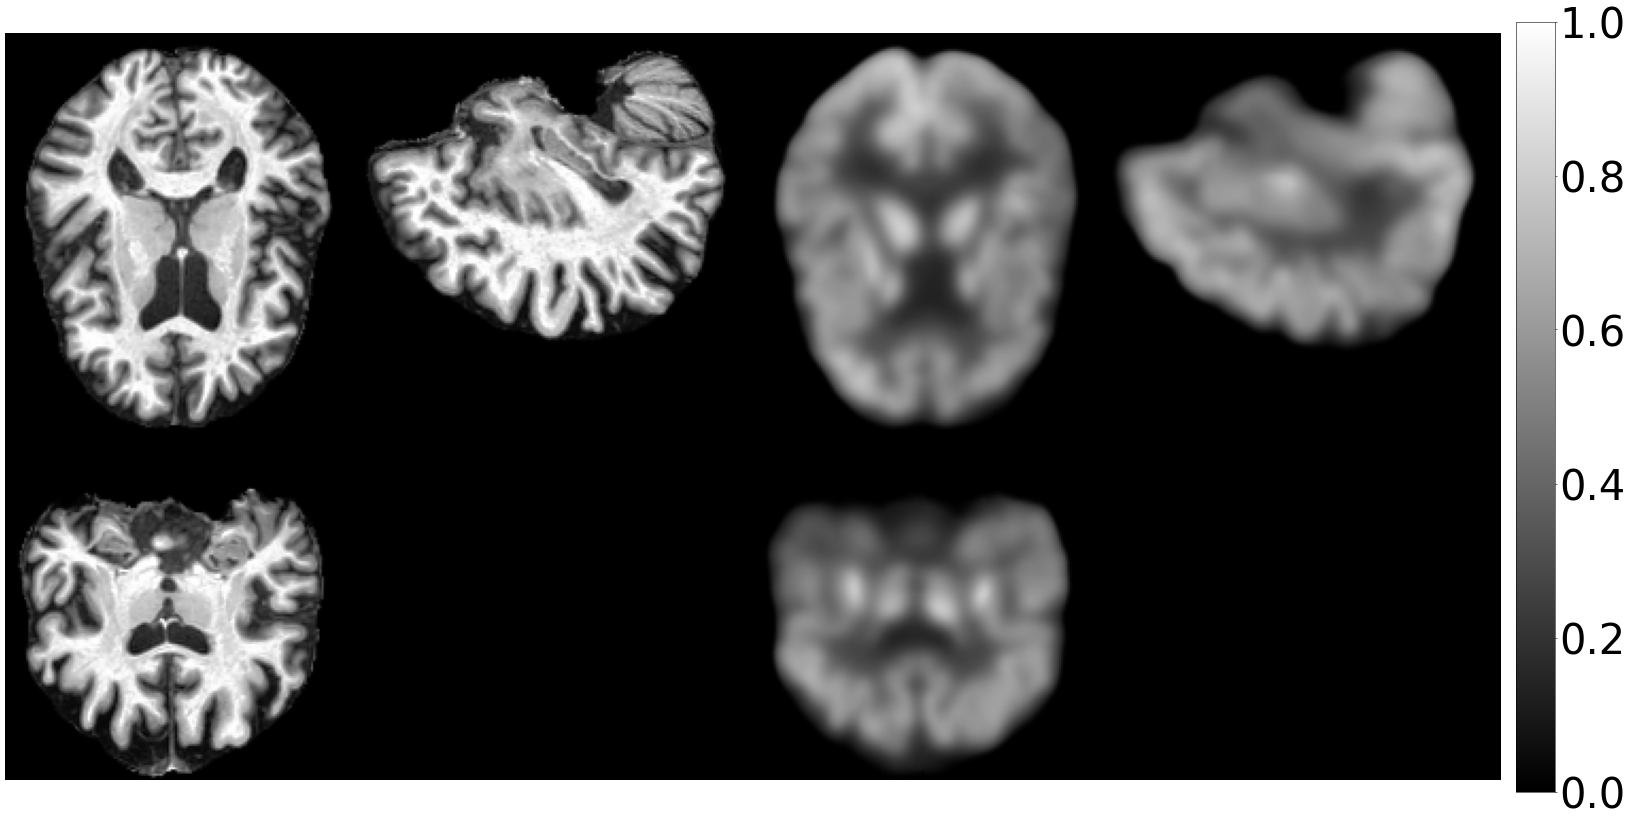

Subject name: 002_S_4171, Label: [0, 1]
Subject name: 029_S_2376, Label: [0, 1]
Subject name: 126_S_4743, Label: [0, 1]
Subject name: 153_S_4077, Label: [0, 1]
Subject name: 053_S_2357, Label: [0, 1]


In [11]:
for batch in val_loader:
    image_1 = batch["mri"]
    label_1 = batch["pet"]
    names = batch["name"]
    labels = batch["label"]
    compare_3d([image_1,label_1])

    # 将整数标签转换为 one-hot 编码格式
    one_hot_labels = []
    for label in labels:
        if label.item() == 0:
            one_hot_labels.append([1, 0])
        elif label.item() == 1:
            one_hot_labels.append([0, 1])

    # 打印样本信息
    for idx, (name, label) in enumerate(zip(names, one_hot_labels)):
        print(f"Subject name: {name}, Label: {label}")

    break


#  Using mri concat syn fdg pet to distinguish MCI from CN

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# 初始化 KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 存储所有折的指标
all_epoch_loss_values = []
all_accuracy_values = []
all_sensitivity_values = []
all_specificity_values = []
all_f1_score_values = []
all_mcc_values = []
all_auc_values = []

# 获取所有样本
all_samples=positive_samples+negative_samples

# 开始三折交叉验证
for fold_idx, (train_indices, val_indices) in enumerate(kf.split(all_samples)):
    print(f"Starting Fold {fold_idx + 1}/3")
    
    # 初始化模型、损失函数和优化器
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=2, out_channels=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 初始化存储当前折的训练损失和验证指标
    epoch_loss_values = []
    accuracy_values = []
    sensitivity_values = []
    specificity_values = []
    f1_score_values = []
    mcc_values = []
    auc_values = []

    best_metric = -1
    best_metric_epoch = -1

    # 开始训练
    max_epochs = 200
    val_interval = 2
    for epoch in range(max_epochs):
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        # 训练部分
        for batch_data in train_loader:
            step += 1
            mri_images = batch_data["mri"].to(device)
            pet_images = batch_data["pet"].to(device)
            labels = torch.tensor(batch_data["label"], dtype=torch.long).to(device)
            combined = torch.cat((mri_images, pet_images), dim=1)

            if labels.dim() == 2:  # 转换 one-hot 编码标签为类索引
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(combined)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 计算并保存平均训练损失
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # 验证部分每隔 val_interval 进行一次
        if (epoch + 1) % val_interval == 0:
            model.eval()
            y_true = []
            y_pred = []
            y_prob = []

            for val_data in val_loader:
                val_mri_images = val_data["mri"].to(device)
                val_pet_images = val_data["pet"].to(device)
                val_labels = torch.tensor(val_data["label"], dtype=torch.long).to(device)
                val_combined = torch.cat((val_mri_images, val_pet_images), dim=1)
                if val_labels.dim() == 2:
                    val_labels = torch.argmax(val_labels, dim=1)

                with torch.no_grad():
                    val_outputs = model(val_combined)
                    preds = val_outputs.argmax(dim=1)
                    y_true.extend(val_labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    y_prob.extend(val_outputs[:, 1].cpu().numpy())  # 概率用于 AUC 计算

            # 计算混淆矩阵和各项指标
            cm = confusion_matrix(y_true, y_pred)
            TN, FP, FN, TP = cm.ravel()  # 从混淆矩阵中提取 TN, FP, FN, TP

            acc = (TP + TN) / (TP + TN + FP + FN)  # 准确率
            sen = TP / (TP + FN)  # 敏感性
            spe = TN / (TN + FP)  # 特异性
            f1 = f1_score(y_true, y_pred)  # F1 分数
            mcc = matthews_corrcoef(y_true, y_pred)  # MCC
            auc = roc_auc_score(y_true, y_prob)  # AUC

            # 保存每个指标的值
            accuracy_values.append(acc)
            sensitivity_values.append(sen)
            specificity_values.append(spe)
            f1_score_values.append(f1)
            mcc_values.append(mcc)
            auc_values.append(auc)

            print(f"Fold {fold_idx + 1}, ACC: {acc:.4f}, SEN: {sen:.4f}, SPE: {spe:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}, AUC: {auc:.4f}")

            # 保存模型
            if acc > best_metric:
                best_metric = acc
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model_fold_{fold_idx + 1}.pth")
                print(f"Fold {fold_idx + 1}: saved new best metric model")

    # 保存当前折的指标
    all_epoch_loss_values.append(epoch_loss_values)
    all_accuracy_values.append(accuracy_values)
    all_sensitivity_values.append(sensitivity_values)
    all_specificity_values.append(specificity_values)
    all_f1_score_values.append(f1_score_values)
    all_mcc_values.append(mcc_values)
    all_auc_values.append(auc_values)

    print(f"Fold {fold_idx + 1} completed.")

# 打印所有折的平均指标
print("Cross-validation completed. Calculating average metrics...")

mean_accuracy = np.mean([np.mean(acc) for acc in all_accuracy_values])
mean_sensitivity = np.mean([np.mean(sen) for sen in all_sensitivity_values])
mean_specificity = np.mean([np.mean(spe) for spe in all_specificity_values])
mean_f1 = np.mean([np.mean(f1) for f1 in all_f1_score_values])
mean_mcc = np.mean([np.mean(mcc) for mcc in all_mcc_values])
mean_auc = np.mean([np.mean(auc) for auc in all_auc_values])

print(f"Average Accuracy: {mean_accuracy:.4f}")
print(f"Average Sensitivity: {mean_sensitivity:.4f}")
print(f"Average Specificity: {mean_specificity:.4f}")
print(f"Average F1 Score: {mean_f1:.4f}")
print(f"Average MCC: {mean_mcc:.4f}")
print(f"Average AUC: {mean_auc:.4f}")

# 绘制平均训练损失和验证指标曲线
epochs = range(1, len(all_epoch_loss_values[0]) + 1)
val_epochs = range(val_interval, max_epochs + 1, val_interval)

plt.figure(figsize=(12, 8))

# 平均训练损失曲线
plt.subplot(2, 2, 1)
mean_train_loss = np.mean(all_epoch_loss_values, axis=0)
plt.plot(epochs, mean_train_loss, label='Average Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training Loss over Epochs')
plt.legend()

# 平均验证准确率曲线
plt.subplot(2, 2, 2)
mean_val_acc = np.mean(all_accuracy_values, axis=0)
plt.plot(val_epochs, mean_val_acc, label='Average Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy over Epochs')
plt.legend()

# 平均 F1 Score 曲线
plt.subplot(2, 2, 3)
mean_val_f1 = np.mean(all_f1_score_values, axis=0)
plt.plot(val_epochs, mean_val_f1, label='Average F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average F1 Score over Epochs')
plt.legend()

# 平均 AUC 曲线
plt.subplot(2, 2, 4)
mean_val_auc = np.mean(all_auc_values, axis=0)
plt.plot(val_epochs, mean_val_auc, label='Average AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Average AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Using synthetic FDG PET to differentiate between MCI and CN

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# 初始化 KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 存储所有折的指标
all_epoch_loss_values = []
all_accuracy_values = []
all_sensitivity_values = []
all_specificity_values = []
all_f1_score_values = []
all_mcc_values = []
all_auc_values = []

# 获取所有样本
all_samples=positive_samples+negative_samples

# 开始三折交叉验证
for fold_idx, (train_indices, val_indices) in enumerate(kf.split(all_samples)):
    print(f"Starting Fold {fold_idx + 1}/3")
    
    # 初始化模型、损失函数和优化器
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 初始化存储当前折的训练损失和验证指标
    epoch_loss_values = []
    accuracy_values = []
    sensitivity_values = []
    specificity_values = []
    f1_score_values = []
    mcc_values = []
    auc_values = []

    best_metric = -1
    best_metric_epoch = -1

    # 开始训练
    max_epochs = 200
    val_interval = 2
    for epoch in range(max_epochs):
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        # 训练部分
        for batch_data in train_loader:
            step += 1
            pet_images = batch_data["pet"].to(device)
            labels = torch.tensor(batch_data["label"], dtype=torch.long).to(device)

            if labels.dim() == 2:  # 转换 one-hot 编码标签为类索引
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(pet_images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 计算并保存平均训练损失
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # 验证部分每隔 val_interval 进行一次
        if (epoch + 1) % val_interval == 0:
            model.eval()
            y_true = []
            y_pred = []
            y_prob = []

            for val_data in val_loader:
                val_pet_images = val_data["pet"].to(device)
                val_labels = torch.tensor(val_data["label"], dtype=torch.long).to(device)
                if val_labels.dim() == 2:
                    val_labels = torch.argmax(val_labels, dim=1)

                with torch.no_grad():
                    val_outputs = model(val_pet_images)
                    preds = val_outputs.argmax(dim=1)
                    y_true.extend(val_labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    y_prob.extend(val_outputs[:, 1].cpu().numpy())  # 概率用于 AUC 计算

            # 计算混淆矩阵和各项指标
            cm = confusion_matrix(y_true, y_pred)
            TN, FP, FN, TP = cm.ravel()  # 从混淆矩阵中提取 TN, FP, FN, TP

            acc = (TP + TN) / (TP + TN + FP + FN)  # 准确率
            sen = TP / (TP + FN)  # 敏感性
            spe = TN / (TN + FP)  # 特异性
            f1 = f1_score(y_true, y_pred)  # F1 分数
            mcc = matthews_corrcoef(y_true, y_pred)  # MCC
            auc = roc_auc_score(y_true, y_prob)  # AUC

            # 保存每个指标的值
            accuracy_values.append(acc)
            sensitivity_values.append(sen)
            specificity_values.append(spe)
            f1_score_values.append(f1)
            mcc_values.append(mcc)
            auc_values.append(auc)

            print(f"Fold {fold_idx + 1}, ACC: {acc:.4f}, SEN: {sen:.4f}, SPE: {spe:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}, AUC: {auc:.4f}")

            # 保存模型
            if acc > best_metric:
                best_metric = acc
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model_fold_{fold_idx + 1}.pth")
                print(f"Fold {fold_idx + 1}: saved new best metric model")

    # 保存当前折的指标
    all_epoch_loss_values.append(epoch_loss_values)
    all_accuracy_values.append(accuracy_values)
    all_sensitivity_values.append(sensitivity_values)
    all_specificity_values.append(specificity_values)
    all_f1_score_values.append(f1_score_values)
    all_mcc_values.append(mcc_values)
    all_auc_values.append(auc_values)

    print(f"Fold {fold_idx + 1} completed.")

# 打印所有折的平均指标
print("Cross-validation completed. Calculating average metrics...")

mean_accuracy = np.mean([np.mean(acc) for acc in all_accuracy_values])
mean_sensitivity = np.mean([np.mean(sen) for sen in all_sensitivity_values])
mean_specificity = np.mean([np.mean(spe) for spe in all_specificity_values])
mean_f1 = np.mean([np.mean(f1) for f1 in all_f1_score_values])
mean_mcc = np.mean([np.mean(mcc) for mcc in all_mcc_values])
mean_auc = np.mean([np.mean(auc) for auc in all_auc_values])

print(f"Average Accuracy: {mean_accuracy:.4f}")
print(f"Average Sensitivity: {mean_sensitivity:.4f}")
print(f"Average Specificity: {mean_specificity:.4f}")
print(f"Average F1 Score: {mean_f1:.4f}")
print(f"Average MCC: {mean_mcc:.4f}")
print(f"Average AUC: {mean_auc:.4f}")

# 绘制平均训练损失和验证指标曲线
epochs = range(1, len(all_epoch_loss_values[0]) + 1)
val_epochs = range(val_interval, max_epochs + 1, val_interval)

plt.figure(figsize=(12, 8))

# 平均训练损失曲线
plt.subplot(2, 2, 1)
mean_train_loss = np.mean(all_epoch_loss_values, axis=0)
plt.plot(epochs, mean_train_loss, label='Average Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training Loss over Epochs')
plt.legend()

# 平均验证准确率曲线
plt.subplot(2, 2, 2)
mean_val_acc = np.mean(all_accuracy_values, axis=0)
plt.plot(val_epochs, mean_val_acc, label='Average Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy over Epochs')
plt.legend()

# 平均 F1 Score 曲线
plt.subplot(2, 2, 3)
mean_val_f1 = np.mean(all_f1_score_values, axis=0)
plt.plot(val_epochs, mean_val_f1, label='Average F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average F1 Score over Epochs')
plt.legend()

# 平均 AUC 曲线
plt.subplot(2, 2, 4)
mean_val_auc = np.mean(all_auc_values, axis=0)
plt.plot(val_epochs, mean_val_auc, label='Average AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Average AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#Using MRI to distinguish MCI from CN

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# 初始化 KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 存储所有折的指标
all_epoch_loss_values = []
all_accuracy_values = []
all_sensitivity_values = []
all_specificity_values = []
all_f1_score_values = []
all_mcc_values = []
all_auc_values = []

# 获取所有样本
all_samples = positive_samples + negative_samples

# 开始三折交叉验证
for fold_idx, (train_indices, val_indices) in enumerate(kf.split(all_samples)):
    print(f"Starting Fold {fold_idx + 1}/3")
    
    # 初始化模型、损失函数和优化器
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 初始化存储当前折的训练损失和验证指标
    epoch_loss_values = []
    accuracy_values = []
    sensitivity_values = []
    specificity_values = []
    f1_score_values = []
    mcc_values = []
    auc_values = []

    best_metric_sum = -1  # 记录 AUC + ACC 的最大值
    best_metric_epoch = -1
    best_metrics = {}  # 记录最佳模型的各项指标

    # 开始训练
    max_epochs = 200
    val_interval = 2
    for epoch in range(max_epochs):
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        # 训练部分
        for batch_data in train_loader:
            step += 1
            mri_images = batch_data["mri"].to(device)
            labels = torch.tensor(batch_data["label"], dtype=torch.long).to(device)

            if labels.dim() == 2:  # 转换 one-hot 编码标签为类索引
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(mri_images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 计算并保存平均训练损失
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Fold {fold_idx + 1}, Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # 验证部分每隔 val_interval 进行一次
        if (epoch + 1) % val_interval == 0:
            model.eval()
            y_true = []
            y_pred = []
            y_prob = []

            for val_data in val_loader:
                val_mri_images = val_data["mri"].to(device)
                val_labels = torch.tensor(val_data["label"], dtype=torch.long).to(device)
                if val_labels.dim() == 2:
                    val_labels = torch.argmax(val_labels, dim=1)

                with torch.no_grad():
                    val_outputs = model(val_mri_images)
                    preds = val_outputs.argmax(dim=1)
                    y_true.extend(val_labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    y_prob.extend(val_outputs[:, 1].cpu().numpy())  # 概率用于 AUC 计算

            # 计算混淆矩阵和各项指标
            cm = confusion_matrix(y_true, y_pred)
            TN, FP, FN, TP = cm.ravel()  # 从混淆矩阵中提取 TN, FP, FN, TP

            acc = (TP + TN) / (TP + TN + FP + FN)  # 准确率
            sen = TP / (TP + FN)  # 敏感性
            spe = TN / (TN + FP)  # 特异性
            f1 = f1_score(y_true, y_pred)  # F1 分数
            mcc = matthews_corrcoef(y_true, y_pred)  # MCC
            auc = roc_auc_score(y_true, y_prob)  # AUC

            # 计算 AUC + ACC 的总和
            metric_sum = auc + acc

            # 如果发现新的最大值，则更新最佳模型的指标和 epoch
            if metric_sum > best_metric_sum:
                best_metric_sum = metric_sum
                best_metric_epoch = epoch + 1
                best_metrics = {
                    "ACC": acc,
                    "SEN": sen,
                    "SPE": spe,
                    "F1": f1,
                    "MCC": mcc,
                    "AUC": auc,
                }
                torch.save(model.state_dict(), f"best_model_fold_{fold_idx + 1}.pth")
                print(f"Fold {fold_idx + 1}: saved new best metric model at epoch {best_metric_epoch}")

            # 保存每个指标的值
            accuracy_values.append(acc)
            sensitivity_values.append(sen)
            specificity_values.append(spe)
            f1_score_values.append(f1)
            mcc_values.append(mcc)
            auc_values.append(auc)

            print(f"Fold {fold_idx + 1}, ACC: {acc:.4f}, SEN: {sen:.4f}, SPE: {spe:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}, AUC: {auc:.4f}, Metric Sum: {metric_sum:.4f}")

    # 保存当前折的指标
    all_epoch_loss_values.append(epoch_loss_values)
    all_accuracy_values.append(accuracy_values)
    all_sensitivity_values.append(sensitivity_values)
    all_specificity_values.append(specificity_values)
    all_f1_score_values.append(f1_score_values)
    all_mcc_values.append(mcc_values)
    all_auc_values.append(auc_values)

    print(f"Fold {fold_idx + 1} completed. Best Metric Sum: {best_metric_sum:.4f} at epoch {best_metric_epoch}")

# 打印所有折的平均指标
print("Cross-validation completed. Calculating average metrics...")

mean_accuracy = np.mean([np.mean(acc) for acc in all_accuracy_values])
mean_sensitivity = np.mean([np.mean(sen) for sen in all_sensitivity_values])
mean_specificity = np.mean([np.mean(spe) for spe in all_specificity_values])
mean_f1 = np.mean([np.mean(f1) for f1 in all_f1_score_values])
mean_mcc = np.mean([np.mean(mcc) for mcc in all_mcc_values])
mean_auc = np.mean([np.mean(auc) for auc in all_auc_values])

print(f"Average Accuracy: {mean_accuracy:.4f}")
print(f"Average Sensitivity: {mean_sensitivity:.4f}")
print(f"Average Specificity: {mean_specificity:.4f}")
print(f"Average F1 Score: {mean_f1:.4f}")
print(f"Average MCC: {mean_mcc:.4f}")
print(f"Average AUC: {mean_auc:.4f}")

# 绘制平均训练损失和验证指标曲线
epochs = range(1, len(all_epoch_loss_values[0]) + 1)
val_epochs = range(val_interval, max_epochs + 1, val_interval)

plt.figure(figsize=(12, 8))

# 平均训练损失曲线
plt.subplot(2, 2, 1)
mean_train_loss = np.mean(all_epoch_loss_values, axis=0)
plt.plot(epochs, mean_train_loss, label='Average Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training Loss over Epochs')
plt.legend()

# 平均验证准确率曲线
plt.subplot(2, 2, 2)
mean_val_acc = np.mean(all_accuracy_values, axis=0)
plt.plot(val_epochs, mean_val_acc, label='Average Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy over Epochs')
plt.legend()

# 平均 F1 Score 曲线
plt.subplot(2, 2, 3)
mean_val_f1 = np.mean(all_f1_score_values, axis=0)
plt.plot(val_epochs, mean_val_f1, label='Average F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average F1 Score over Epochs')
plt.legend()

# 平均 AUC 曲线
plt.subplot(2, 2, 4)
mean_val_auc = np.mean(all_auc_values, axis=0)
plt.plot(val_epochs, mean_val_auc, label='Average AUC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Average AUC over Epochs')
plt.legend()

plt.tight_layout()
plt.show()